### Transfer Learning for Garbage Classification 

The data is classified based on 

In [1]:
# Importing useful libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import os
import matplotlib.pyplot as plt
import time
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.metrics import confusion_matrix
import pandas as pd

cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [2]:
# Performing necessary preprocessing stages to resize the images according to the image size used in the pretrained model. 
#Also, mean and std of images should be scaled acoording to the ImageNet dataset. 
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}    

In [3]:
# Loading train and validation datasets and creating dataloaders
batch_size = 8

data_dir = r'Dataset/CVPR_2024_dataset'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Train', 'Validation']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=1)
               for x in ['Train', 'Validation']}

dataset_sizes = {x: len(image_datasets[x])
                 for x in ['Train', 'Validation']}

class_names = image_datasets['Train'].classes
print(class_names)

# Loading test dataset
test_dir = r'Dataset/CVPR_2024_dataset/Test'

test_dataset = datasets.ImageFolder(os.path.join(test_dir), data_transforms['Validation'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

['Black', 'Blue', 'Green', 'TTR']


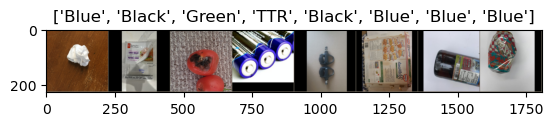

In [4]:
# Visualizing some train images
def imshow(img, title=None):
    img = img.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['Train']))
outputs = torchvision.utils.make_grid(inputs)

imshow(outputs, title=[class_names[x] for x in classes])

In [5]:
# Defining our model
def garbage_model(model, criterion, optimizer, LR_scheduler, num_epochs):

    # creating a temporary directory to save our model
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0

        # The main training loop
        for epoch in range(num_epochs):
            print(f'Epoch {epoch} / {num_epochs - 1}')
            print('_' * 10)


            # Each epoch has training and validation phase
            for phase in ['Train', 'Validation']:
                if phase == 'Train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device) # to send batches to the GPU

                    optimizer.zero_grad() # Everytime we set the optimizer zero to avoid residuals from previous iteration

                    with torch.set_grad_enabled(phase=='Train'): # Updating parameters in the training phase
                        outputs = model(inputs) # sending one batch of images to the model to get probability values
                        _,preds = torch.max(outputs, 1) # finding the label with the highest probability value
                        loss = criterion(outputs, labels) # calculating the loss

                        if phase == 'Train':
                            loss.backward() # with the loss value, we do the gradient descent in the backpropagation
                            optimizer.step() # Updating the weights of the model

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds==labels.data)

                if phase == 'Train':
                    LR_scheduler.step()


                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print(f'{phase}: Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


                if phase == 'Validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path) # saving the best model

            print()

        print(f'Best validation accuracy: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))

    return model

In [6]:
# The model that we choose is ConvNeXtBase due to its highes accuracy for our problem. 
model = models.convnext_base(weights='IMAGENET1K_V1')
for param in model.parameters(): # we freeze the parameters as we do not want to compute gradients for those parameters
   param.requires_grad = False

model.classifier[2] = torch.nn.Linear(in_features=model.classifier[2].in_features, out_features=4)
    
model = model.to(device)

criterion = nn.CrossEntropyLoss() # Defining loss function

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001) # Defining optimizer

LR_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [7]:
model = garbage_model(model, criterion, optimizer, LR_scheduler, num_epochs=30)

Epoch 0 / 29
__________
Train: Loss: 0.6886 Acc: 0.7479
Validation: Loss: 0.5864 Acc: 0.8055

Epoch 1 / 29
__________
Train: Loss: 0.5816 Acc: 0.7859
Validation: Loss: 0.5742 Acc: 0.8005

Epoch 2 / 29
__________
Train: Loss: 0.5621 Acc: 0.7905
Validation: Loss: 0.5754 Acc: 0.7995

Epoch 3 / 29
__________
Train: Loss: 0.5534 Acc: 0.7930
Validation: Loss: 0.5569 Acc: 0.8095

Epoch 4 / 29
__________
Train: Loss: 0.5627 Acc: 0.7909
Validation: Loss: 0.5656 Acc: 0.7895

Epoch 5 / 29
__________
Train: Loss: 0.5391 Acc: 0.8014
Validation: Loss: 0.5616 Acc: 0.8065

Epoch 6 / 29
__________
Train: Loss: 0.5459 Acc: 0.7920
Validation: Loss: 0.5637 Acc: 0.8050

Epoch 7 / 29
__________
Train: Loss: 0.5197 Acc: 0.8050
Validation: Loss: 0.5496 Acc: 0.8070

Epoch 8 / 29
__________
Train: Loss: 0.5169 Acc: 0.8034
Validation: Loss: 0.5438 Acc: 0.8080

Epoch 9 / 29
__________
Train: Loss: 0.5098 Acc: 0.8086
Validation: Loss: 0.5399 Acc: 0.8090

Epoch 10 / 29
__________
Train: Loss: 0.5151 Acc: 0.8066
Val

In [8]:
correct = 0
total = 0
y_pred = []
y_true = []

# We do not calculate the gradients as we are not in the training phase
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
  
        y_true.extend(labels.data.cpu().numpy())

        outputs = model(images) # Sending one batch to the model to calculate the output (prabability value)
        

        _, predicted = torch.max(outputs.data, 1) # Finding the label with the highiest probability value
        y_pred.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total} %')

# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Accuracy per class
Acc_class = cm.diagonal()/cm.sum(axis=1) 
Acc_per_class = {}
j = 0
for i in class_names:
    Acc_per_class[i] = Acc_class[j]
    j += 1
print("Accuracy per class:", Acc_per_class)

# Creating pandas dataframe
dataframe = pd.DataFrame(cm, index=class_names, columns=class_names)
dataframe

Accuracy of the model on the test images: 79.6 %
Accuracy per class: {'Black': 0.642, 'Blue': 0.894, 'Green': 0.868, 'TTR': 0.78}


,Black,Blue,Green,TTR
Black,321,130,24,25
Blue,31,447,13,9
Green,13,51,434,2
TTR,37,64,9,390
